In [2]:
using TimeSeries
using DataFrames
import Proj4
using Optim
using Distances
using Statistics
using Printf
;

In [3]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [4]:
using Revise
import TempModel
using GaussianProcesses

# Data Import and Preprocessing

In [5]:
include("iowa.jl")
data_dir = "../data"
iowa = prepare_iowa_data(data_dir);

┌ Warning: dropmissing! will change eltype of cols to disallow missing by default. Use dropmissing!(df, cols, disallowmissing=false) to retain missing.
│   caller = dropmissing!(::DataFrame) at abstractdataframe.jl:733
└ @ DataFrames /Users/imolk/Library/Julia/alternative_depots/climate/packages/DataFrames/IKMvt/src/abstractdataframe/abstractdataframe.jl:733


# `sumprod` sum of products kernel

In [17]:
function make_kernel()
    kt1 = Periodic(log(1.0),log(3.0),log(24.0))
    kt2 = RQIso(log(0.5),0.0,0.0)  # half an hour
    kt3 = RQIso(log(2.0),0.0,0.0)  # two hours
    kt4 = RQIso(log(12.0),0.0,0.0) # twelve hours

    ksp1 = Mat32Iso(log(5e4), log(1.0))
    ksp2 = Mat32Iso(log(5e4), log(1.0))
    ksp3 = Mat32Iso(log(5e4), log(1.0))
    ksp4 = Mat32Iso(log(5e4), log(1.0))
    
    k_means = SEIso(log(1), log(40.0))
    
    kprod(ktime, kspace) = Masked(ktime, [1]) * 
                           Masked(fix(kspace, :lσ), [2,3])

    k_spatiotemporal = kprod(fix(kt1, :lp), ksp1) +
                       kprod(kt2, ksp2) +
                       kprod(kt3, ksp3) +
                       kprod(kt4, ksp4) +
                       fix(Masked(k_means, [2,3]))
    return Dict(
        :time1=>kt1, :time2=>kt2, :time3=>kt3, :time4=>kt4,
        :space1=>ksp1, :space2=>ksp2, :space3=>ksp3, :space4=>ksp4,
        :mean=>k_means,
        :spatiotemporal => k_spatiotemporal
        )
end

function showkernel(kdict, logNoise)
    print("k₁: Periodic \n=================\n")
    Printf.@printf("σ: %5.3f\n", √kdict[:time1].σ2)
    Printf.@printf("l: %5.3f\n", √kdict[:time1].ℓ2)
    Printf.@printf("p: %5.0f hours\n", kdict[:time1].p)
    print("> spatial decay:\n")
    Printf.@printf("l: %5.3f km\n", kdict[:space1].ℓ / 1000)
    print("\nk₂: RQIso \n=================\n")
    Printf.@printf("σ: %5.3f\n", √kdict[:time2].σ2)
    Printf.@printf("l: %5.3f hours\n", √kdict[:time2].ℓ2)
    Printf.@printf("α: %5.3f\n", kdict[:time2].α)
    print("> spatial decay:\n")
    # @printf("σ: %5.3f\n", √ksp2.σ2)
    Printf.@printf("l: %5.3f km\n", kdict[:space2].ℓ / 1000)
    print("\nk₃: SEIso \n=================\n")
    Printf.@printf("σ: %5.3f\n", √kdict[:time3].σ2)
    Printf.@printf("l: %5.3f hours\n", √kdict[:time3].ℓ2)
    print("> spatial decay:\n")
    # @printf("σ: %5.3f\n", √ksp3.σ2)
    Printf.@printf("l: %5.3f km\n", kdict[:space3].ℓ / 1000)
    print("\nk₄: RQIso \n=================\n")
    Printf.@printf("σ: %5.3f\n", √kdict[:time4].σ2)
    Printf.@printf("l: %5.3f days\n", √kdict[:time4].ℓ2 / 24)
    Printf.@printf("α: %5.3f\n",  kdict[:time4].α)
    print("> spatial decay:\n")
    # @printf("σ: %5.3f\n", √ksp4.σ2)
    Printf.@printf("l: %5.3f km\n", kdict[:space4].ℓ / 1000)
    print("\n=================\n")
    Printf.@printf("σy: %5.3f\n", exp(logNoise))
end
;

# optimize

In [7]:
kdict = make_kernel()
@time opt_out = TempModel.optim_kernel(kdict[:spatiotemporal], 0.0, iowa[:isdSubset], iowa[:hourly_data], :Optim);

creating GP chunks
begin optimization
12142.078597 seconds (23.91 M allocations: 5.082 GiB, 0.04% gc time)


In [8]:
opt_out[:mll]

-45954.01395589189

In [9]:
print(opt_out[:hyp])

[-1.72345, -0.200617, 1.00724, 14.0155, -1.20079, -0.702929, -1.0738, 9.43453, 0.678858, -0.0280216, 0.245475, 11.1962, 2.18657, 1.45589, -0.924679, 13.3049]

In [10]:
opt_out[:opt_out]

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [-1.7234518578886573,-0.20061731518124634, ...]
 * Minimum: 4.595401e+04
 * Iterations: 214
 * Convergence: true
   * |x - x'| ≤ 1.0e-05: false 
     |x - x'| = 5.22e-05 
   * |f(x) - f(x')| ≤ 1.0e-10 |f(x)|: true
     |f(x) - f(x')| = 6.76e-11 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 3.27e-01 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 445
 * Gradient Calls: 234

# Printing and plotting fitted variogram

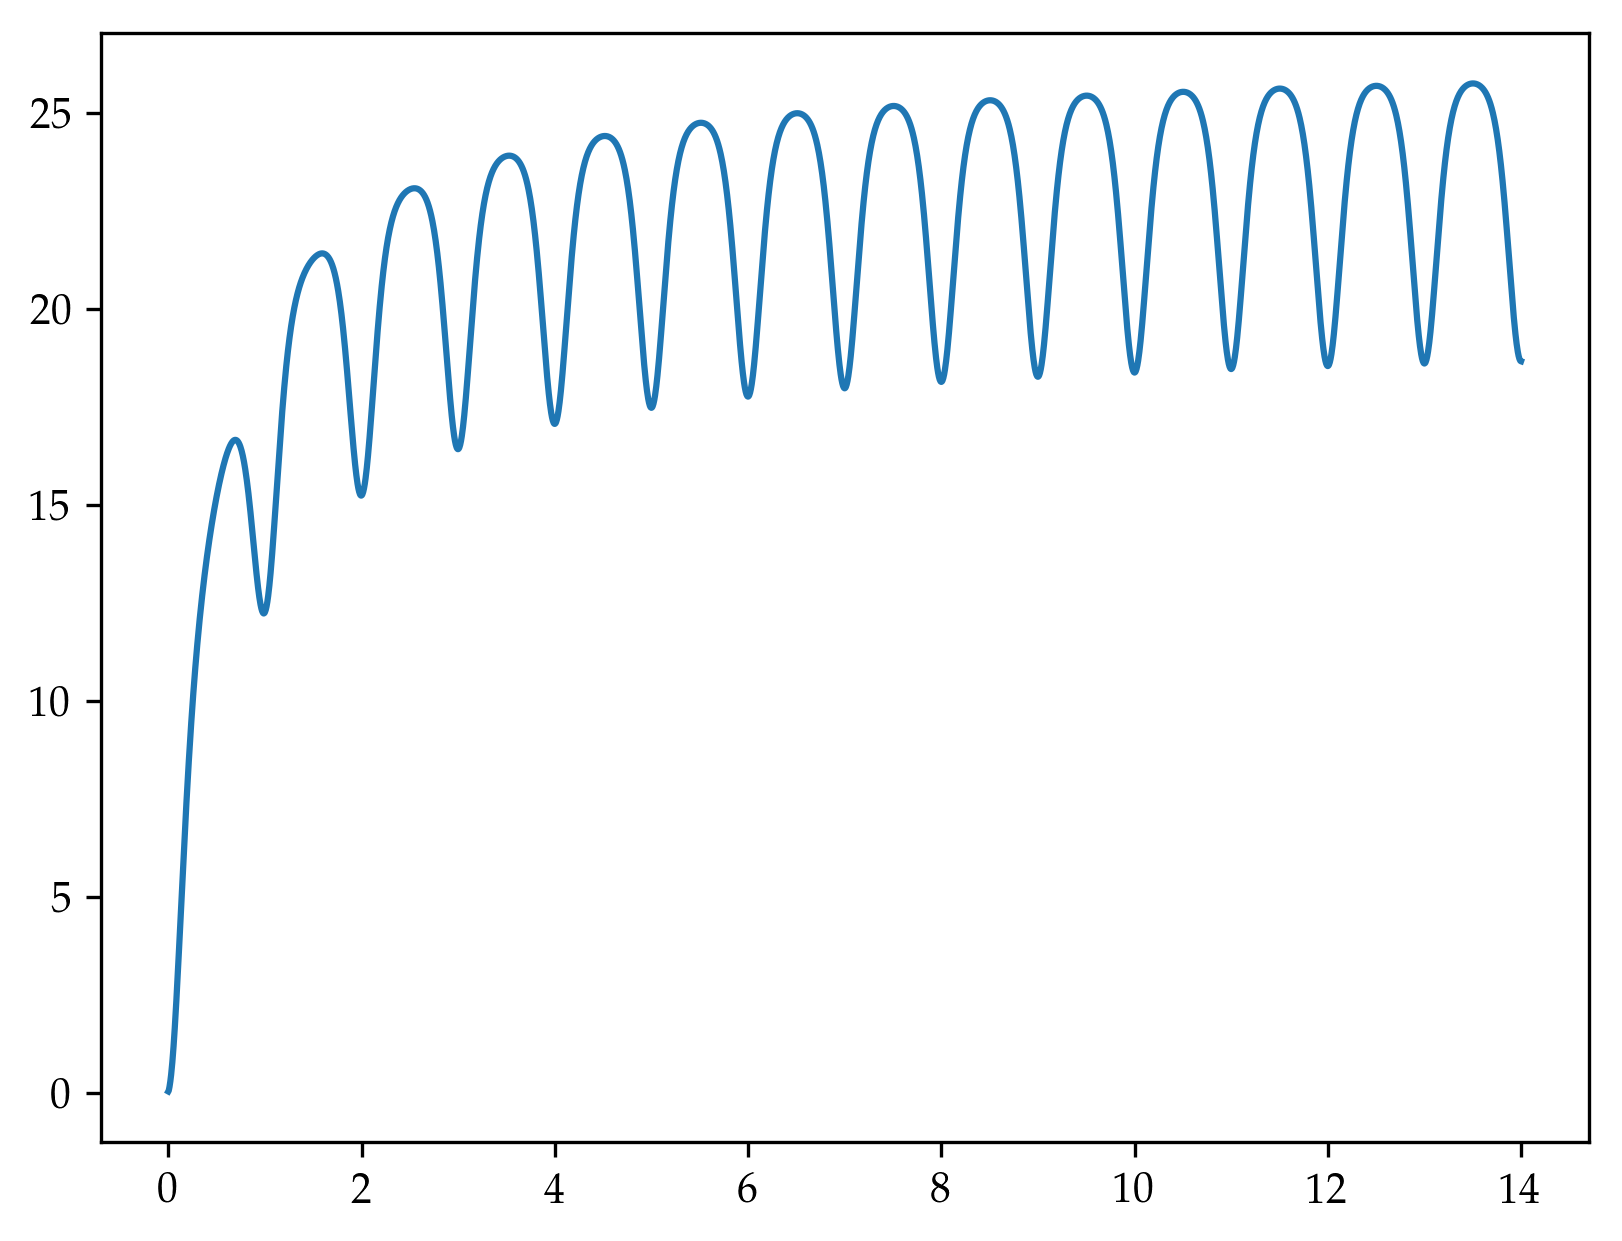

k₁: Periodic 
σ: 2.738
l: 0.818
p:    24 hours
> spatial decay:
l: 1221.442 km

k₂: RQIso 
σ: 0.495
l: 0.301 hours
α: 0.342
> spatial decay:
l: 12.513 km

k₃: SEIso 
σ: 0.972
l: 1.972 hours
> spatial decay:
l: 72.851 km

k₄: RQIso 
σ: 4.288
l: 0.371 days
α: 0.397
> spatial decay:
l: 600.131 km

σy: 0.178


In [19]:
kdict = make_kernel()
hyp = opt_out[:hyp]
set_params!(kdict[:spatiotemporal], hyp[2:end])
showkernel(kdict, hyp[1])

σ2_y = exp(2*opt_out[:hyp][1])
rr = range(0.0, stop=24*14, step=0.1)
ck_r = [cov(kdict[:spatiotemporal], [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, σ2_y + ck_r[1].-ck_r, label="fitted variogram")
;

# Using cross-validation metric

In [22]:
# start with the fitted marginal likelihood parameters
kdict = make_kernel()
hyp = opt_out[:hyp]
set_params!(kdict[:spatiotemporal], hyp[2:end])

@time opt_out_CV = TempModel.optim_kernel_CV(kdict[:spatiotemporal], hyp[1], 
                                           iowa[:isdSubset], iowa[:hourly_data],
                                           window=Day(8), # shorter window is faster
                                           :Optim);
opt_out_CV

creating GP chunks
begin optimization
23313.114836 seconds (176.34 G allocations: 7.906 TiB, 10.36% gc time)


Dict{Symbol,Any} with 4 entries:
  :mll      => -43852.3
  :hyp      => [-1.72312, -0.563792, 0.428389, 14.0385, -1.33832, -0.846743, -0…
  :logNoise => -1.72312
  :opt_out  => Results of Optimization Algorithm…

In [26]:
print(opt_out_CV[:hyp])

[-1.72312, -0.563792, 0.428389, 14.0385, -1.33832, -0.846743, -0.630146, 9.4281, 0.451994, -0.298897, 0.783025, 10.8419, 1.65669, 1.11078, 0.408934, 12.9025]

In [25]:
kdict = make_kernel()
hyp = opt_out_CV[:hyp]
set_params!(kdict[:spatiotemporal], hyp[2:end])
showkernel(kdict, hyp[1])

k₁: Periodic 
σ: 1.535
l: 0.569
p:    24 hours
> spatial decay:
l: 1249.764 km

k₂: RQIso 
σ: 0.429
l: 0.262 hours
α: 0.533
> spatial decay:
l: 12.433 km

k₃: SEIso 
σ: 0.742
l: 1.571 hours
> spatial decay:
l: 51.120 km

k₄: RQIso 
σ: 3.037
l: 0.218 days
α: 1.505
> spatial decay:
l: 401.321 km

σy: 0.179


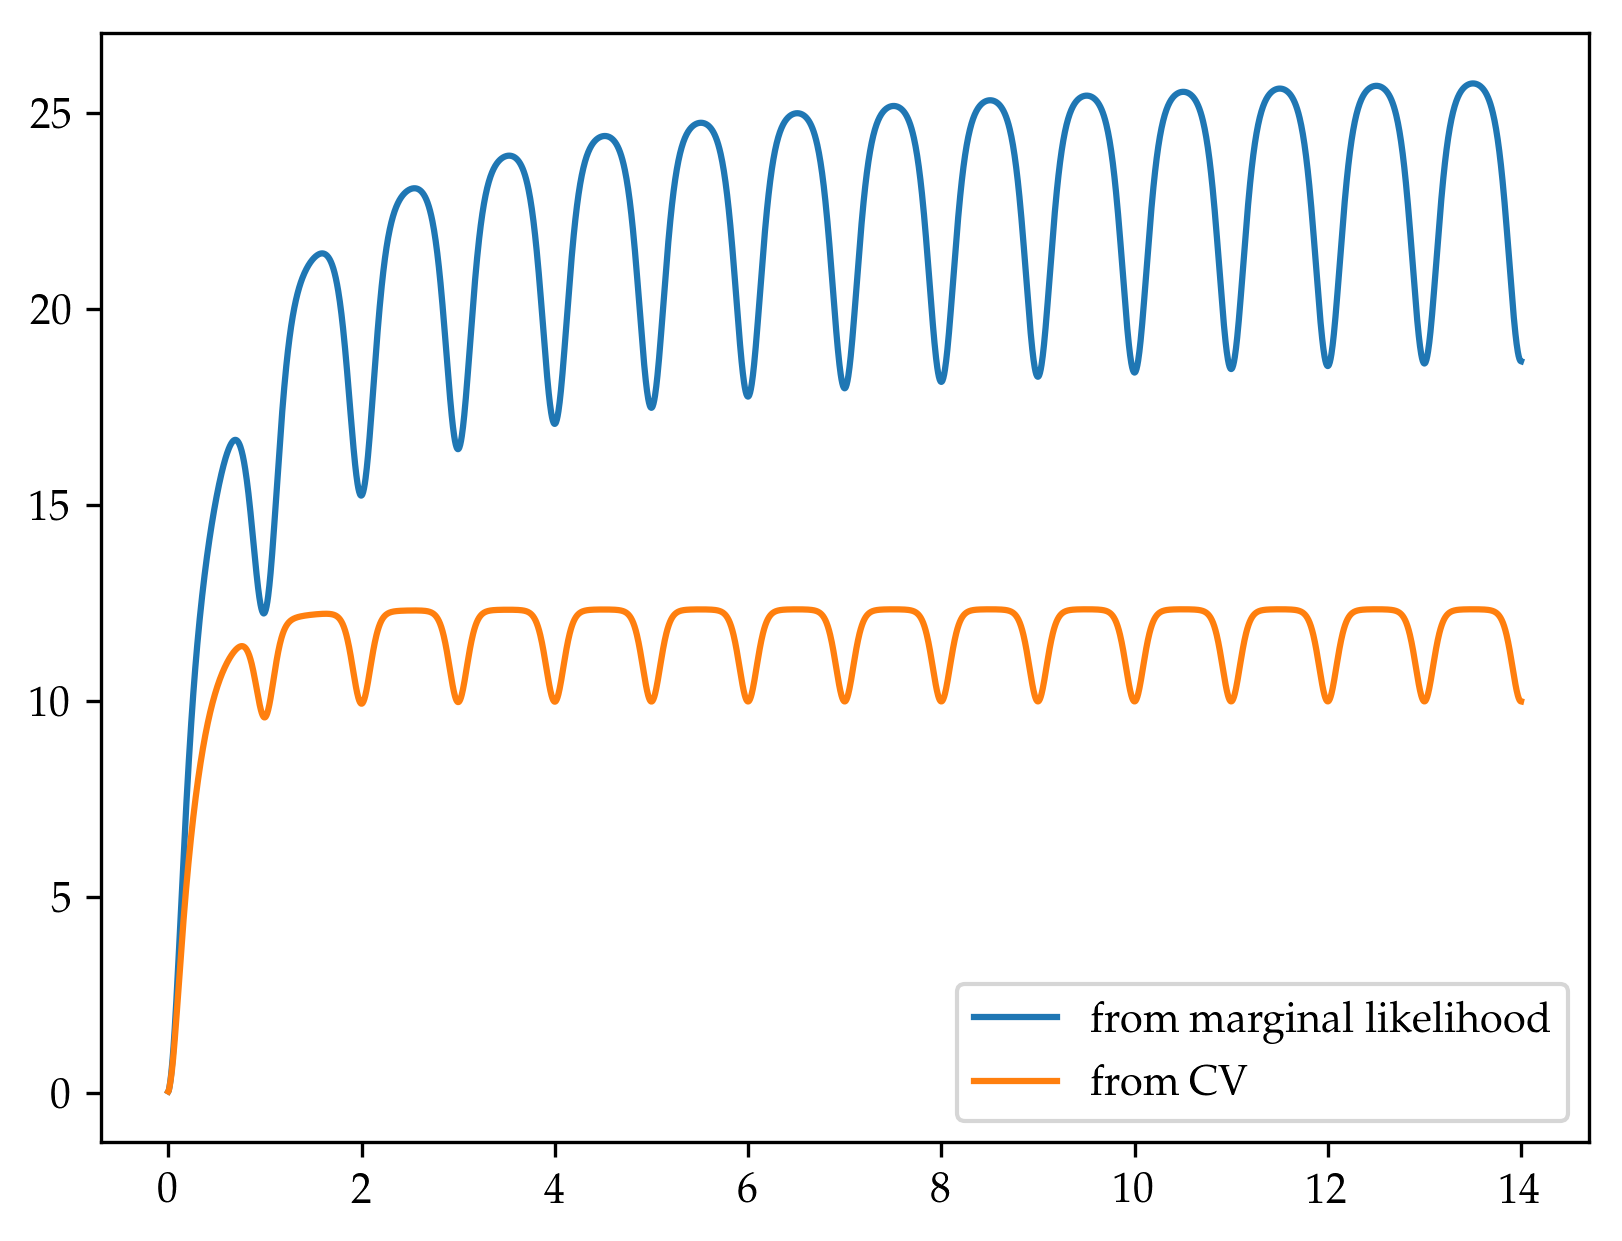

PyObject <matplotlib.legend.Legend object at 0x123f85550>

In [24]:
kdict = make_kernel()
hyp = opt_out[:hyp]
set_params!(kdict[:spatiotemporal], hyp[2:end])

σ2_y = exp(2*opt_out[:hyp][1])
rr = range(0.0, stop=24*14, step=0.1)
ck_r = [cov(kdict[:spatiotemporal], [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, σ2_y + ck_r[1].-ck_r, label="from marginal likelihood")
;
kdict = make_kernel()
hyp = opt_out_CV[:hyp]
set_params!(kdict[:spatiotemporal], hyp[2:end])

σ2_y = exp(2*opt_out_CV[:hyp][1])
rr = range(0.0, stop=24*14, step=0.1)
ck_r = [cov(kdict[:spatiotemporal], [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, σ2_y + ck_r[1].-ck_r, label="from CV")
;
plt.legend(loc="best")

That's actually a very different variogram!
It seems the model is no longer bothering to fit well at high timescales.
It makes sense that it would make very little difference to the quality of predictions,
where simultaneous observations are always available.
Another interesting phenomenon is that the variance parameter of each component has gone down by quite a lot.
This is significant as we were seeing overly conservative (inflated) predictive variances,
which were hurting the imputations.
There's good reason to believe this will solve that problem.